In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'HDFCBANK.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,3.030000,3.030000,2.925000,2.980000,2.362860,350000
1996-01-02,2.980000,3.025000,2.950000,2.975000,2.358896,412000
1996-01-03,2.975000,2.995000,2.950000,2.985000,2.366826,284000
1996-01-04,2.985000,2.980000,2.940000,2.965000,2.350967,282000
1996-01-05,2.965000,2.980000,2.950000,2.960000,2.347002,189000
...,...,...,...,...,...,...
2024-04-25,1506.250000,1519.699951,1506.250000,1510.750000,1510.750000,17722602
2024-04-26,1519.800049,1528.000000,1505.550049,1509.800049,1509.800049,12427347
2024-04-29,1515.000000,1534.449951,1506.550049,1529.500000,1529.500000,18046675


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
221/221 [==============================] - 21s 12ms/step - loss: 0.0061
Epoch 2/50
221/221 [==============================] - 3s 12ms/step - loss: 0.0016
Epoch 3/50
221/221 [==============================] - 3s 12ms/step - loss: 0.0014
Epoch 4/50
221/221 [==============================] - 3s 14ms/step - loss: 0.0014
Epoch 5/50
221/221 [==============================] - 3s 12ms/step - loss: 0.0013
Epoch 6/50
221/221 [==============================] - 2s 11ms/step - loss: 0.0012
Epoch 7/50
221/221 [==============================] - 3s 11ms/step - loss: 0.0010
Epoch 8/50
221/221 [==============================] - 3s 12ms/step - loss: 0.0011
Epoch 9/50
221/221 [==============================] - 3s 16ms/step - loss: 0.0011
Epoch 10/50
221/221 [==============================] - 3s 12ms/step - loss: 0.0010
Epoch 11/50
221/221 [==============================] - 3s 11ms/step - loss: 9.6331e-04
Epoch 12/50
221/221 [==============================] - 3s 11ms/step - loss: 9.4401e-04
Epoc

1/1 [==============================] - 0s 21ms/step


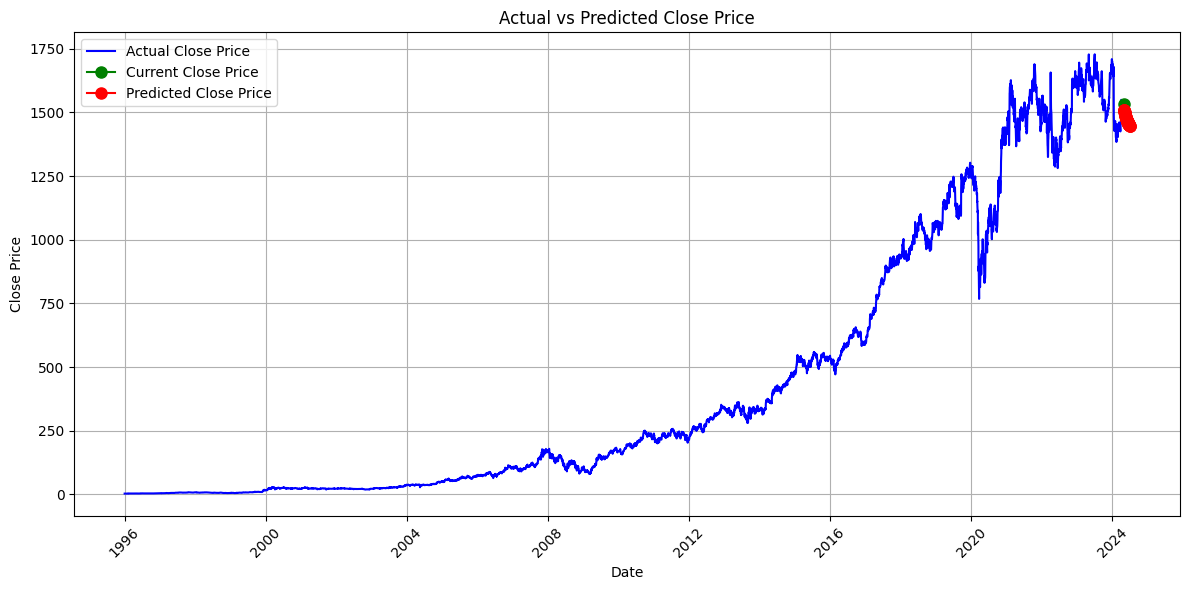

In [8]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted_prices

array([1511.0323, 1511.0496, 1509.0706, 1506.0554, 1502.8641, 1500.0015,
       1497.6698, 1495.8535, 1494.4156, 1493.1835, 1492.0062, 1490.7843,
       1489.4752, 1488.082 , 1486.6356, 1485.1766, 1483.7416, 1482.3558,
       1481.0309, 1479.7668, 1478.5563, 1477.3884, 1476.2527, 1475.1414,
       1474.0493, 1472.9751, 1471.9187, 1470.8818, 1469.8661, 1468.8728,
       1467.9025, 1466.9551, 1466.0299, 1465.1263, 1464.2429, 1463.3789,
       1462.5334, 1461.706 , 1460.8958, 1460.1029, 1459.3265, 1458.5663,
       1457.8223, 1457.0938, 1456.3805, 1455.6821, 1454.9984, 1454.3287,
       1453.673 , 1453.0304, 1452.4011, 1451.7845, 1451.1803, 1450.5884,
       1450.0083, 1449.4398, 1448.8828, 1448.3368, 1447.8016, 1447.2771],
      dtype=float32)

In [10]:
model.save('HDFCBANK.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import joblib
joblib.dump(scaler, 'HDFCBANK.pkl')

['HDFCBANK.pkl']